In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.metrics import roc_auc_score, mean_squared_error, accuracy_score

from tqdm import tqdm

import warnings; warnings.filterwarnings('ignore')

import lightgbm as lgb
import xgboost as xgb
import catboost as cb

from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score


import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import random
import os

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

In [3]:
from pathlib import Path
DATA_PATH = Path("C:/ML_Projects/kaggle-workflow/data/")
OUTPUT_PATH = Path("C:/ML_Projects/kaggle-workflow/output/")

# General settings
SEED = 42
N_FOLDS = 5

# Metric choice placeholder
#Adjust depending on the competition
METRIC = "auc"

In [4]:
#Load Data
train = pd.read_csv(DATA_PATH / "Diabetes Prediction Challenge" / "train.csv")
test = pd.read_csv(DATA_PATH / "Diabetes Prediction Challenge" / "test.csv")

In [5]:
train.columns

Index(['id', 'age', 'alcohol_consumption_per_week',
       'physical_activity_minutes_per_week', 'diet_score',
       'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi',
       'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate',
       'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol',
       'triglycerides', 'gender', 'ethnicity', 'education_level',
       'income_level', 'smoking_status', 'employment_status',
       'family_history_diabetes', 'hypertension_history',
       'cardiovascular_history', 'diagnosed_diabetes'],
      dtype='object')

In [6]:
train = train.rename(columns = ({"alcohol_consumption_per_week":"alc",'physical_activity_minutes_per_week':"activity", 'diet_score':"diet",
                          'sleep_hours_per_day': "sleep", 'screen_time_hours_per_day':"screen", 'education_level':"edu",
                           'income_level':"inc", 'smoking_status': "smoke", 'employment_status':"empl", 'family_history_diabetes': "fam_his",
                          'hypertension_history': "hyp_his", 'cardiovascular_history': "card_his", 'diagnosed_diabetes': "label"} ))
test = test.rename(columns = ({"alcohol_consumption_per_week":"alc",'physical_activity_minutes_per_week':"activity", 'diet_score':"diet",
                          'sleep_hours_per_day': "sleep", 'screen_time_hours_per_day':"screen", 'education_level':"edu",
                           'income_level':"inc", 'smoking_status': "smoke", 'employment_status':"empl", 'family_history_diabetes': "fam_his",
                          'hypertension_history': "hyp_his", 'cardiovascular_history': "card_his", 'diagnosed_diabetes': "label"} ))


In [7]:
cat_features =['gender', 'ethnicity', 'edu', 'inc', 'smoke', 'empl']

num_features = ['age', 'activity', 'sleep', 'screen', 'bmi',
       'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate',
       'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol',
       'triglycerides']

In [8]:
def add_feature_cross_terms(df, numerical_features):
    df_new = df.copy()
    
    for i in range(len(numerical_features)):
        for j in range(i + 1, len(numerical_features)):  
            feature1 = numerical_features[i]
            feature2 = numerical_features[j]
            cross_term_name = f"{feature1}_x_{feature2}"
            df_new[cross_term_name] = df_new[feature1] * df_new[feature2]
            #cross_term_name = f"{feature1}_add_{feature2}"
            #df_new[cross_term_name] = df_new[feature1] + df_new[feature2]
            #cross_term_name = f"{feature1}_divided_{feature2}"
            #df_new[cross_term_name] = df_new[feature1] / df_new[feature2]

    return df_new

train = add_feature_cross_terms(train, num_features)
test = add_feature_cross_terms(test, num_features)

In [9]:
train.head()

,id,age,alc,activity,diet,sleep,screen,bmi,waist_to_hip_ratio,systolic_bp,...,heart_rate_x_cholesterol_total,heart_rate_x_hdl_cholesterol,heart_rate_x_ldl_cholesterol,heart_rate_x_triglycerides,cholesterol_total_x_hdl_cholesterol,cholesterol_total_x_ldl_cholesterol,cholesterol_total_x_triglycerides,hdl_cholesterol_x_ldl_cholesterol,hdl_cholesterol_x_triglycerides,ldl_cholesterol_x_triglycerides
0,0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,...,12338,3596,7068,6324,11542,22686,20298,6612,5916,11628
1,1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,...,14129,3550,8591,8804,9950,24079,24676,6050,6200,15004
2,2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,...,13724,4307,8322,7884,11092,21432,20304,6726,6372,12312
3,3,54,3,77,4.6,7.0,9.2,26.6,0.83,121,...,13468,3996,6290,9102,9828,15470,22386,4590,6642,10455
4,4,54,1,55,5.7,6.2,5.1,28.8,0.90,108,...,17510,4165,11135,10540,10094,26986,25544,6419,6076,16244


In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for feature in cat_features:
    train[feature] = le.fit_transform(train[feature])
    test[feature] = le.transform(test[feature])
    train[feature] = train[feature].astype("category")
    test[feature] = test[feature].astype("category")
X = train.drop(columns=["id", "label"])
y = train["label"]
X_test = test.drop(columns=["id"])

In [11]:
import time
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

In [12]:
%%time
FOLDS = 5
FEATURES = train.columns.tolist()

skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof = np.zeros(len(train))
pred = np.zeros(len(test))

for i, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    print(f"\n########## Fold {i+1} ##########")

    X_train = X.iloc[train_idx].copy()
    y_train = y.iloc[train_idx]

    X_valid = X.iloc[valid_idx].copy()
    y_valid = y.iloc[valid_idx]
    x_test = X_test.copy()

    start = time.time()

    model = XGBClassifier(
        tree_method="hist",          # switch to "hist" if no GPU
        max_depth=6,
        min_child_weight=5,
        colsample_bytree=0.8,
        subsample=0.8,
        n_estimators=2000,
        learning_rate=0.03,
        gamma=0.0,
        reg_lambda=1.0,
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        early_stopping_rounds=100,
        enable_categorical=True
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=100
    )

    oof[valid_idx] = model.predict_proba(X_valid)[:, 1]
    pred += model.predict_proba(X_test)[:, 1]

    fold_auc = roc_auc_score(y_valid, oof[valid_idx])
    print(f"Fold {i+1} AUC: {fold_auc:.5f}")
    print(f"Time: {time.time() - start:.1f} sec")

pred /= FOLDS

cv_auc = roc_auc_score(y, oof)
print(f"\nFinal CV AUC: {cv_auc:.5f}")


########## Fold 1 ##########
[0]	validation_0-auc:0.68903
[100]	validation_0-auc:0.70708
[200]	validation_0-auc:0.71416
[300]	validation_0-auc:0.71805
[400]	validation_0-auc:0.72090
[500]	validation_0-auc:0.72198
[600]	validation_0-auc:0.72281
[700]	validation_0-auc:0.72324
[800]	validation_0-auc:0.72352
[900]	validation_0-auc:0.72396
[1000]	validation_0-auc:0.72429
[1100]	validation_0-auc:0.72444
[1200]	validation_0-auc:0.72450
[1238]	validation_0-auc:0.72454
Fold 1 AUC: 0.72457
Time: 203.2 sec

########## Fold 2 ##########
[0]	validation_0-auc:0.68690
[100]	validation_0-auc:0.70557
[200]	validation_0-auc:0.71187
[300]	validation_0-auc:0.71615
[400]	validation_0-auc:0.71867
[500]	validation_0-auc:0.72007
[600]	validation_0-auc:0.72083
[700]	validation_0-auc:0.72140
[800]	validation_0-auc:0.72191
[900]	validation_0-auc:0.72227
[1000]	validation_0-auc:0.72258
[1100]	validation_0-auc:0.72274
[1200]	validation_0-auc:0.72289
[1300]	validation_0-auc:0.72299
[1341]	validation_0-auc:0.72299


In [13]:
test_preds = pred

In [14]:
sub = pd.read_csv(DATA_PATH / "Diabetes Prediction Challenge" / "sample_submission.csv")

In [15]:
sub["diagnosed_diabetes"] = test_preds
sub.head()

,id,diagnosed_diabetes
0,700000,0.514741
1,700001,0.685428
2,700002,0.776267
3,700003,0.408486
4,700004,0.937305


In [16]:
sub.to_csv("dia_submission_1_xgb.csv", index=False)

In [17]:
##CV = 0.72421, LB = 0,69513

In [18]:
ENS_PATH = Path("C:\ML_Projects\kaggle-workflow\competitions\Diabetes Prediction Challenge\Ens")
oof_models = pd.read_csv(ENS_PATH / "oof_predictions.csv")
oof_models.head()

,id,target,oof_pred_MLP,oof_pred_LGBM,oof_pred_Cat,oof_pred_svc
0,0,1.0,0.608593,0.498156,0.470012,0.561891
1,1,1.0,0.644023,0.592414,0.583317,0.594351
2,2,0.0,0.292208,0.248972,0.249189,0.272362
3,3,1.0,0.666945,0.533050,0.532701,0.629540
4,4,1.0,0.748159,0.776689,0.763086,0.702487


In [19]:
xgb_oof = oof

In [20]:
oof_models["oof_pred_xgb"] = xgb_oof
oof_models.head()

,id,target,oof_pred_MLP,oof_pred_LGBM,oof_pred_Cat,oof_pred_svc,oof_pred_xgb
0,0,1.0,0.608593,0.498156,0.470012,0.561891,0.526000
1,1,1.0,0.644023,0.592414,0.583317,0.594351,0.600248
2,2,0.0,0.292208,0.248972,0.249189,0.272362,0.204551
3,3,1.0,0.666945,0.533050,0.532701,0.629540,0.538383
4,4,1.0,0.748159,0.776689,0.763086,0.702487,0.757894


In [25]:
oof_models.to_csv("oof_predictions.csv", index=False)

Text(0.5, 1.0, 'Triangle correlation heatmap')

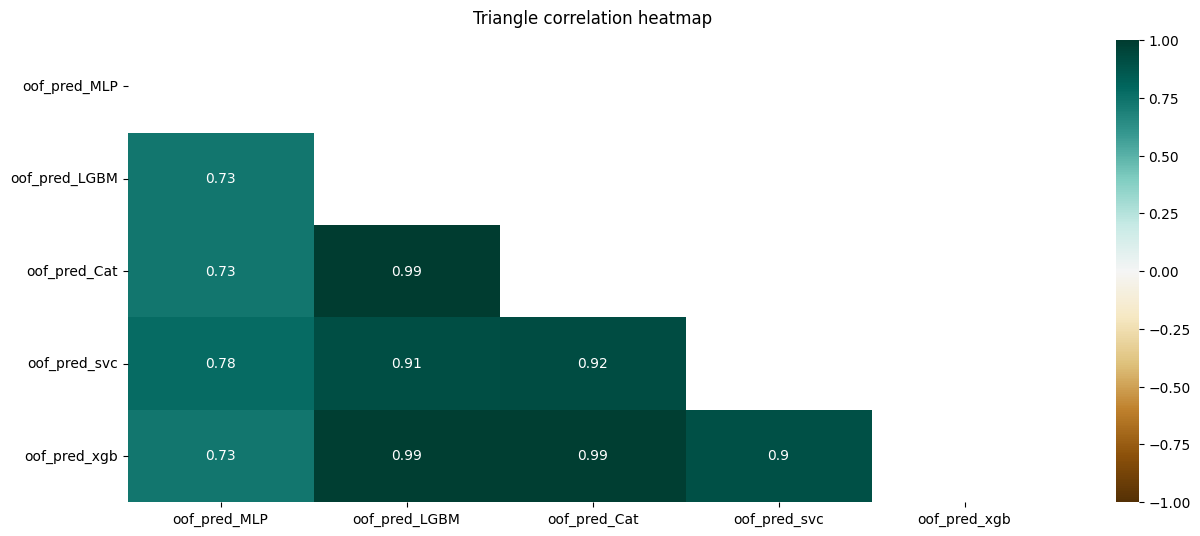

In [21]:
cor_matrix = oof_models.drop(columns = ["id", "target"]).corr()
mask = np.triu(np.ones_like(cor_matrix, dtype = "bool"))
plt.figure(figsize = (15,6))
heatmap = sns.heatmap(cor_matrix, mask = mask, annot=True, vmin = -1, vmax = 1, cmap='BrBG')
heatmap.set_title('Triangle correlation heatmap', fontdict={'fontsize':12}, pad=12)

In [22]:
ENS_PATH = Path("C:\ML_Projects\kaggle-workflow\competitions\Diabetes Prediction Challenge\Ens")
test_pred_models = pd.read_csv(ENS_PATH / "test_pred_models.csv")

In [23]:
test_pred_models["prediction_xgb"] = test_preds
test_pred_models.head()

,id,prediction_MLP,prediction_LGBM,prediction_Cat,prediction_SVC,prediction_xgb
0,0,0.602803,0.505413,0.508414,0.558961,0.514741
1,1,0.642024,0.675915,0.672573,0.572319,0.685428
2,2,0.685453,0.765060,0.786095,0.674510,0.776267
3,3,0.633595,0.408179,0.423093,0.616868,0.408486
4,4,0.867566,0.904486,0.921526,0.805561,0.937305


In [24]:
test_pred_models.to_csv("test_pred_models.csv", index=False)